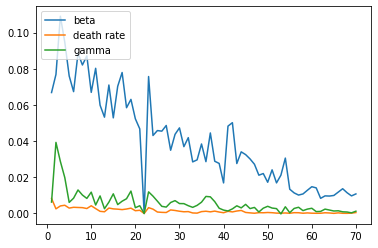

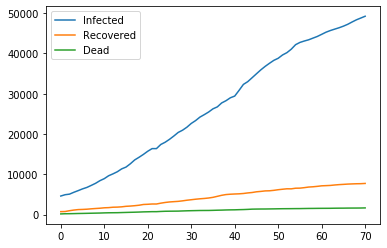

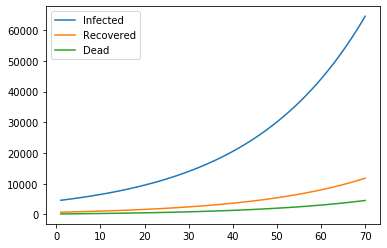

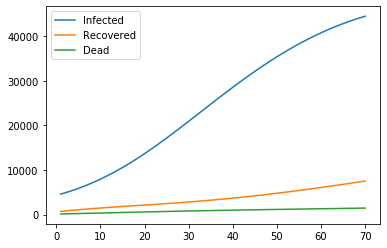

Values of B,Y,u
[0.0482799  0.00704444 0.00279097]
Values of B(t),Y(t),u(t)
[0.00031368 0.00875426 0.08402617] [0.00338116 0.03678575 0.16606175] [0.         0.17702274 0.03969398]


In [12]:
import numpy as np
import math
import pandas
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

def createdummydata(x0,p):
    solution = solve_de(x0,p,endtime = 1000)
    solution = np.flip(solution,axis=0)
    np.savetxt("dummy.csv",solution,delimiter = ',',fmt = '%f')

def import_data():
    data = pandas.read_csv('data.csv').values
    return data

def plot_data(data):
    t = data[:,0]
    s = data[:,1]
    i = data[:,2]
    r = data[:,3]
    d = data[:,4]
    #plt.plot(t,s,label = "Susceptible")
    plt.plot(t,i,label = "Infected")
    plt.plot(t,r,label = "Recovered")
    plt.plot(t,d,label = "Dead")
    plt.legend(loc="upper left")
    plt.show()

def equations(x,p,t):
    #X = current state,p = parameters,t = time
    s = x[0]
    i = x[1]
    r = x[2]
    d = x[3]
    b = p[0]
    g = p[1]
    drate = p[2]
    n = s + i + r + d 
    #Calculation of Derivatives
    ds = -b*i*s/n
    di = b*s*i/n -g*i - drate*i
    dr = g*i
    dd = drate*i
    return np.array([ds,di,dr,dd])

def modequations(x,pb,pg,pd,t):
    s = x[0]
    i = x[1]
    r = x[2]
    d = x[3]
    b = decay(t,pb[0],pb[1],pb[2])
    g = decay(t,pg[0],pg[1],pg[2])
    drate = decay(t,pd[0],pd[1],pd[2])
    n = s + i + r + d 
    #Derivatives
    ds = -b*i*s/n
    di = b*s*i/n -g*i - drate*i
    dr = g*i
    dd = drate*i
    return np.array([ds,di,dr,dd])

def solve_de(x0,p,endtime,div = None):
    #Parameter Initialisation
    if div == None:
        div = math.floor(endtime)
    t = np.linspace(1,endtime,div)
    solve = lambda x,t : equations(x,p,t)
    #Solving the DE's
    x = odeint(solve,x0,t)
    solution = np.hstack([t.reshape((-1,1)),x])
    return solution

def solve_demod(x0,pb,pg,pd,endtime,div = None):
    #Parameter Initialisation
    if div == None:
        div = math.floor(endtime)
    t = np.linspace(1,endtime,div)
    solve = lambda x,t : modequations(x,pb,pg,pd,t)
    #Solving the DE's
    x = odeint(solve,x0,t)
    solution = np.hstack([t.reshape((-1,1)),x])
    return solution

def decay(t,c,o,p):
    return c + o*(1/(1+np.exp(p*t)))
    
def fitbgd(t,b,g,d):
    paramsb,cov = curve_fit(decay,t[1:],b)
    paramsg,cov = curve_fit(decay,t[1:],g)
    paramsd,cov = curve_fit(decay,t[1:],d)
    for j in [paramsb,paramsg,paramsd]:
        if j[0] <0 :
            j[0] = 0
    return paramsb,paramsg,paramsd

def error(predictions,observations):
    len = predictions[:,0].size
    e = (predictions - observations)**2
    e = e[:,1:]
    e = e.sum(axis = 0)
    e = e/len
    e[0] = 0
    return e

def lossfn(x0,p,days,observations):
    a = error(solve_de(x0,p,days),observations)
    return a

def fitDEparams(observations):
    #Initialisation
    x0 = observations[-1]
    x0 = x0[1:]
    observations = observations[0:-1,:]
    observations = np.flip(observations,axis = 0)
    days = observations[:,0].size
    N = x0.sum()
    p0 = [0,0,0]
    #Optimisation 
    loss = lambda p : lossfn(x0,p,days,observations)
    bnds  = ([0,0,0],[1,1,1])
    return (least_squares(loss,p0,bounds = bnds,max_nfev = 20000000,loss = 'linear').x)
    
def inferred_daily(data):
    t = data[:,0]
    s = data[:,1]
    i = data[:,2]
    r = data[:,3]
    d = data[:,4]
    N = s[0] + i[0] + r[0] + d[0]
    b = np.diff(s)*N/(s[:-1]*i[:-1])
    drate = -1*np.diff(d)/i[:-1]
    g = -1*np.diff(r)/i[:-1]
    #Plotting daily inferences
    plt.plot(t[:-1],b,label = "beta")
    plt.plot(t[:-1],drate,label = "death rate")
    plt.plot(t[:-1],g,label = "gamma")
    plt.legend(loc="upper left")
    plt.show()
    return b,g,drate

if __name__ == "__main__":
    #Importing data and finding initial conditions
    data = import_data()
    x0 = data[-1]
    x0 = x0[1:]
    #Finding daily variations in beta,gamma and death rate
    b,g,drate = inferred_daily(data)
    pb,pg,pd = fitbgd(data[:,0],b,g,drate)
    #Solve DE Normally
    params = fitDEparams(data)
    
    solution = solve_de(x0,params,70)
    #Solve Modified DE
    modsolution = solve_demod(x0,pb,pg,pd,70)
    #Plot all the solutions
    plot_data(data)
    plot_data(solution)
    plot_data(modsolution)
    print("Values of B,Y,u")
    print(params)
    print("Values of B(t),Y(t),u(t)")
    print(pd,pg,pb)
    


